# Attempt to create 2D dataset with slices from multiple Datasets.

## Import all required libraries.

In [1]:
import os
import shutil
import random

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from pathlib import Path

## IXI Dataset

#### Dataset with healthy patients from http://brain-development.org/ixi-dataset/
#### Just some examples were downloaded.

### Count number of patients and slices available. The scans shape will be evaluates as well.

In [3]:
ixi_ds_path = Path('../Datasets/Dataset_IXI')
ixi_scans = os.listdir(ixi_ds_path)
len(ixi_scans)

17

In [4]:
for curr_pat in ixi_scans:
    scan_path = os.path.join(ixi_ds_path, curr_pat)
    f = nib.load(scan_path)
    scan_array = f.get_fdata()

    print(scan_array.shape)

(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)
(256, 256, 150)


### All patients have the same shape. Let's check the quality of end slices.

#### For every scan, some images from beggining and someones from the end was display.
#### The plots displayed contain the slices at the extreme indexes in which all scans present good quality images.

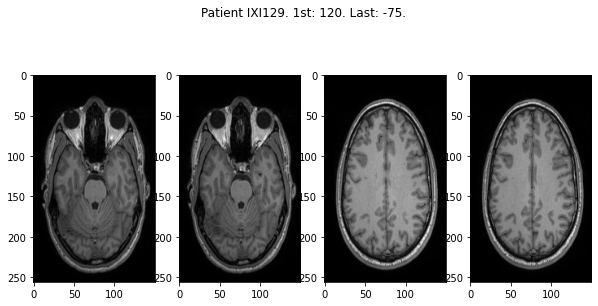

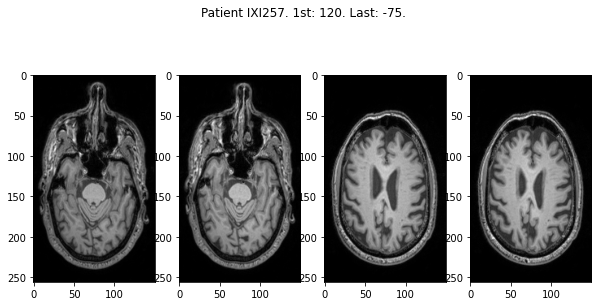

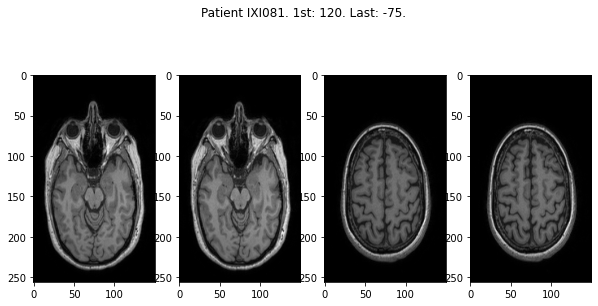

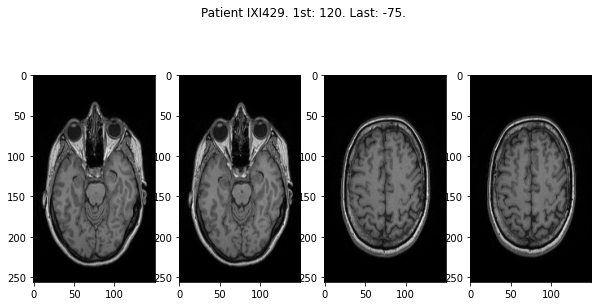

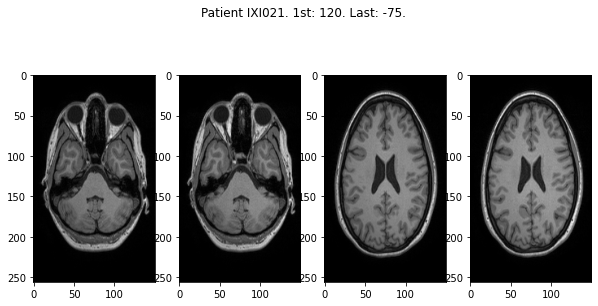

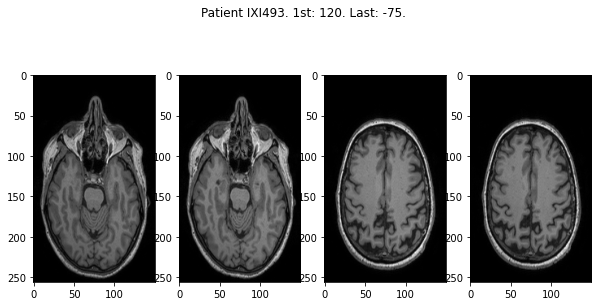

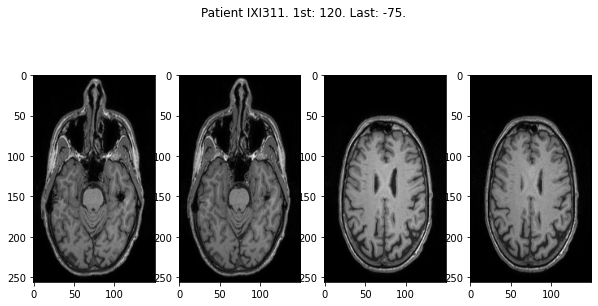

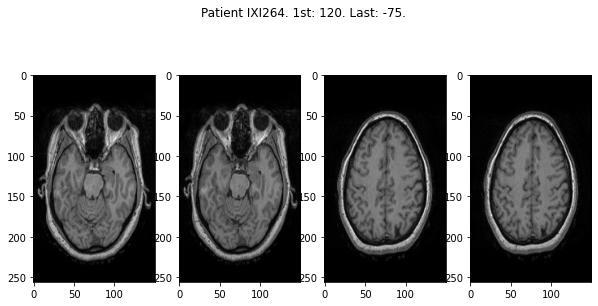

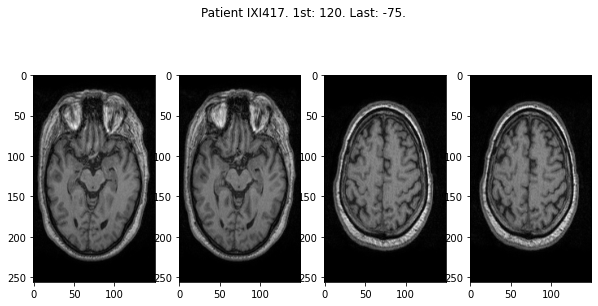

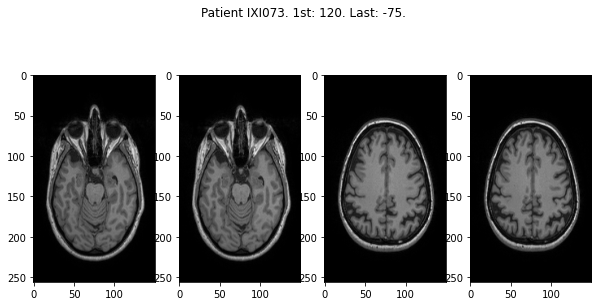

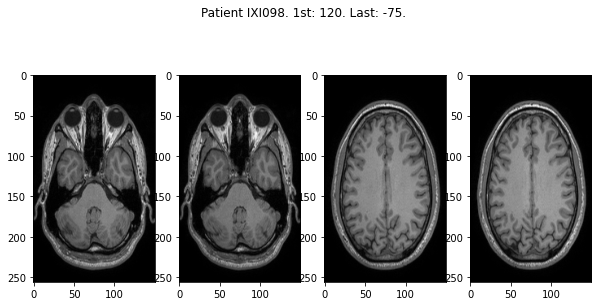

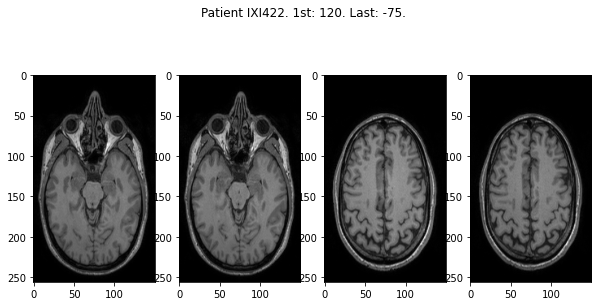

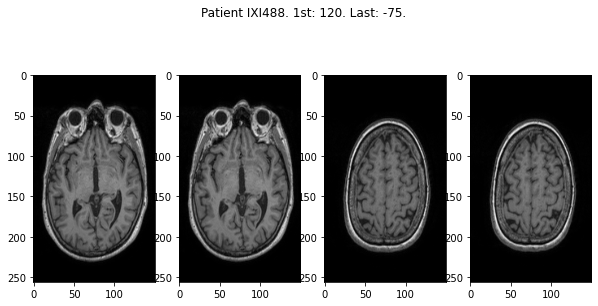

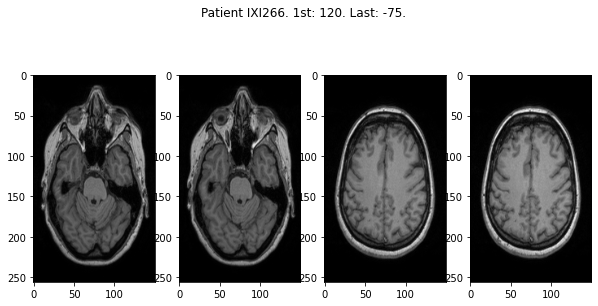

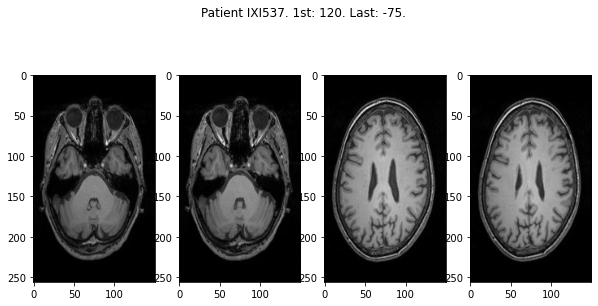

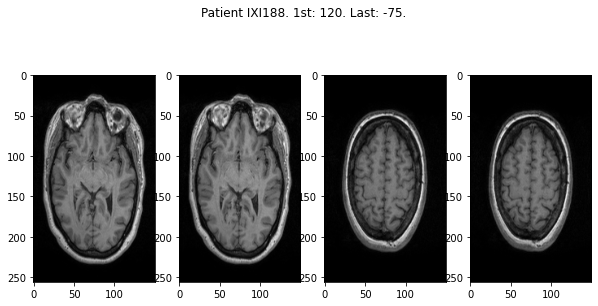

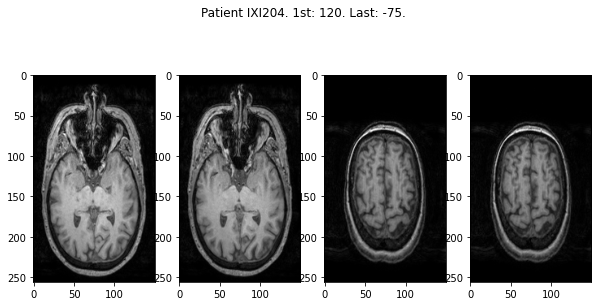

In [5]:
FIRST_IDX = 120
LAST_IDX = -75
slice_idx = [FIRST_IDX,FIRST_IDX+1,LAST_IDX-1, LAST_IDX]

for curr_pat in ixi_scans:

    scan_path = os.path.join(ixi_ds_path, curr_pat)
    f = nib.load(scan_path)
    scan_array = f.get_fdata()

    fig = plt.figure(figsize=(10,5))
    fig.suptitle(f"Patient {curr_pat.split('-')[0]}. 1st: {FIRST_IDX}. Last: {LAST_IDX}.")

    sub_figs = list(map(lambda i: fig.add_subplot(1,4,i), range(1, 5)))
    plots = list(map(lambda idx, sf: sf.imshow(scan_array[:,idx,:], cmap='gray'), slice_idx, sub_figs))

    plt.show()

### Considering that slices with a spacing of at least 4 cuts will be adopted, the maximum total number of images that this sample can provide is calculated below.
### Recall that the original dataset has many scans.

In [24]:
img_from_sample = len(ixi_scans) * (scan_array.shape[1] - FIRST_IDX + LAST_IDX) // 5
img_p_scan = img_from_sample/len(ixi_scans)

img_from_sample, img_p_scan

(207, 12.176470588235293)

## MatLab Dataset

### Originally provided in MatLab, references, credits and more details can be found in https://figshare.com/articles/brain_tumor_dataset/1512427
### After read in python, data was stored in a pandas dataframe.

In [2]:
df = pd.read_pickle('../Datasets/MatLab_DS/matlab_ds.pickle').sort_values(by=['Patient_ID'])
df.head()

Orig_File Patient_ID                                        Slice_Image  \
0        1.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2451   447.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 13, 10, 9,...   
2450   446.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 11, 11, 13,...   
2449   445.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 10, 14, ...   
2448   444.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 10, 9, 11, ...   

                                             Tumor_Mask  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2451  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2450  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2449  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2448  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           Tumor_Border  Tumor_Label  
0     [[267.6152450090744, 231.37568058076226, 277.8...          1.0  
2451  [[238.40911338152915, 224.45345796407378, 229....          1.0  
2450  [[215.91515538541768, 209.98342034735677, 202....          1.0  
2449  [[221.3807236406518, 201.7712422925288, 206.93...          1.0  
2448  [[193.64235098849971, 204.88280408018042, 188....          1.0

### The original dataset contains image with sagittal, coronal and axial views. We are interested just in axial views.

### The first idea is to check if the same patient has different axis views.

In [3]:
patients = df.Patient_ID.unique()
len(patients)

233

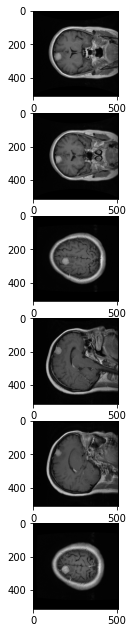

In [4]:
chosen_pat = random.choice(patients)

pat_df = df[df['Patient_ID'] == chosen_pat]

fig = plt.figure(figsize=(10,len(pat_df)+5))

sub_figs = list(map(lambda i: fig.add_subplot(len(pat_df),1,i), range(1, len(pat_df)+1)))
plots = list(map(lambda img, sf: sf.imshow(img, cmap='gray'), pat_df.Slice_Image, sub_figs))

plt.show()

### It was shown above that the same patient can have different image views.

### The sagittal and coronal sections have content up to the right border. The first approach will be to select images that have a black (or at least dark) band on the right edge.

### The choice of what is a dark band is subjective.

In [12]:
NUM_DARK_COLUMNS = 18
DARK_LIMIT = 110

slice_results = []

for img in df.Slice_Image:
    right_edge = img[:,-NUM_DARK_COLUMNS:]
    
    higher_values = right_edge[right_edge > DARK_LIMIT]

    slice_results.append(len(higher_values) is 0)

slice_results = np.array(slice_results)
len(slice_results), len(slice_results[slice_results == True])

(3064, 739)

In [13]:
df['Axial_View'] = slice_results
df.head(10)

Orig_File Patient_ID                                        Slice_Image  \
0        1.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2451   447.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 10, 13, 10, 9,...   
2450   446.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 11, 11, 13,...   
2449   445.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 8, 10, 14, ...   
2448   444.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 10, 9, 11, ...   
2447   443.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 9, 14, 19, ...   
2446   442.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 11, 18, ...   
2509     5.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2398     4.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2222     3.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             Tumor_Mask  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2451  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2450  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2449  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2448  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2447  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2446  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2509  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2398  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2222  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           Tumor_Border  Tumor_Label  \
0     [[267.6152450090744, 231.37568058076226, 277.8...          1.0   
2451  [[238.40911338152915, 224.45345796407378, 229....          1.0   
2450  [[215.91515538541768, 209.98342034735677, 202....          1.0   
2449  [[221.3807236406518, 201.7712422925288, 206.93...          1.0   
2448  [[193.64235098849971, 204.88280408018042, 188....          1.0   
2447  [[208.8596010743536, 203.8509775473907, 191.83...          1.0   
2446  [[213.4958975764211, 213.97245091922562, 205.3...          1.0   
2509  [[286.32752613240416, 231.9163763066202, 297.0...          1.0   
2398  [[279.191637630662, 237.26829268292684, 293.46...          1.0   
2222  [[280.08362369337976, 173.0452961672474, 273.8...          1.0   

      Axial_View  
0           True  
2451       False  
2450       False  
2449       False  
2448       False  
2447       False  
2446       False  
2509        True  
2398        True  
2222        True

### Check if all slices have the same shape.

In [14]:
dict_shapes = {}

axial_df = df[df['Axial_View'] == True]

for idx, row in axial_df.iterrows():
    shape = row['Slice_Image'].shape
    if shape not in dict_shapes:
        dict_shapes.update({shape : 1})
    else:
        dict_shapes[shape] += 1

dict_shapes

{(512, 512): 739}

### Same procedure will be adopted to verify the qualities of the images from this datasets.

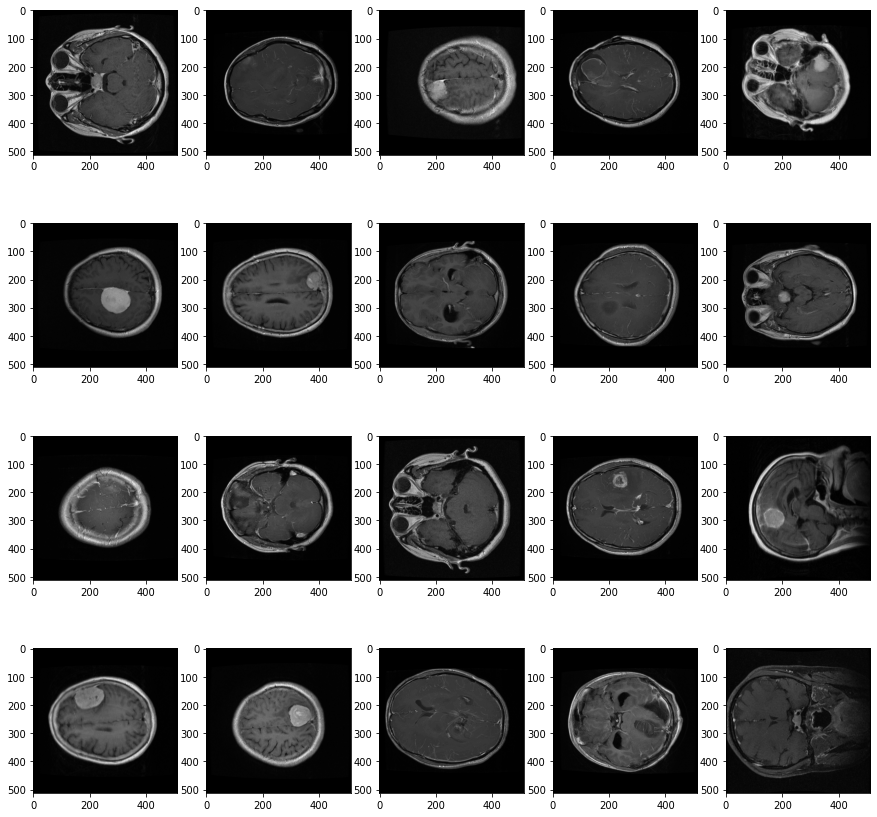

In [16]:
random_images = random.sample(list(axial_df.Slice_Image), 20)

fig= plt.figure(figsize=(15,15))

sub_figs = list(map(lambda i: fig.add_subplot(4,5,i), range(1, 21)))
plots = list(map(lambda img, sf: sf.imshow(img, cmap='gray'), random_images, sub_figs))

plt.show()

### There are still images from other visions. They will have to be removed later.

In [17]:
axial_df.to_pickle('../Datasets/MatLab_DS/axial_df.pickle')

## HCP Dataset.

### This dataset was obtained from the Human Connectome Project (HCP) from the bucket available in AWS.
### That's just a sample of all available patients.

In [62]:
main_folder = Path('../Datasets/HCP/hcp')

pat_ids = os.listdir(main_folder)

for pat in pat_ids:
    pat_folder = os.path.join(main_folder, pat)

    if os.listdir(os.path.join(pat_folder, 'T1w')) == []:
        shutil.rmtree(pat_folder)

remain_pids = os.listdir(main_folder)

len(pat_ids), len(remain_pids)

(98, 42)

### Let's verify if shapes are consistent.

In [72]:
dict_shapes = {}

nifti_filename = os.listdir(os.path.join(main_folder, remain_pids[0], 'T1w'))[0]

for pat in remain_pids:
    scan = os.path.join(main_folder, pat, 'T1w', nifti_filename)

    f = nib.load(scan)
    scan_shape = f.get_fdata().shape

    if scan_shape not in dict_shapes:
        dict_shapes.update({scan_shape : 1})
    else:
        dict_shapes[scan_shape] += 1

dict_shapes

{(145, 174, 145): 42}

### The shapes are the same. As exhibited below, the axial view is obtained in the last index.

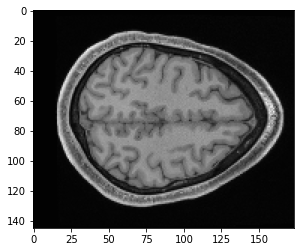

In [73]:
plt.imshow(f.get_fdata()[:,:,100], cmap='gray')
plt.show()

### Now the interesting slices must be selected.

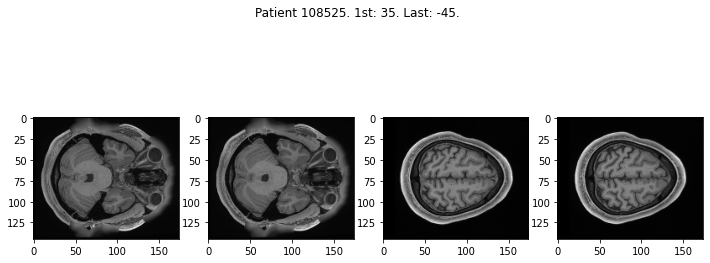

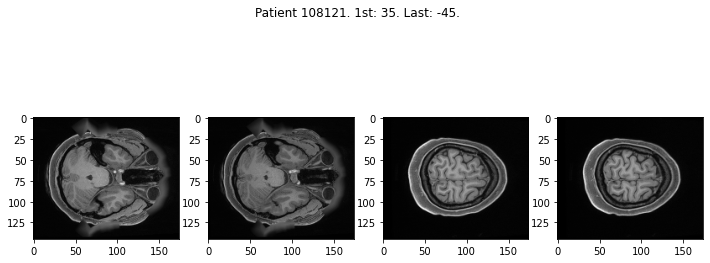

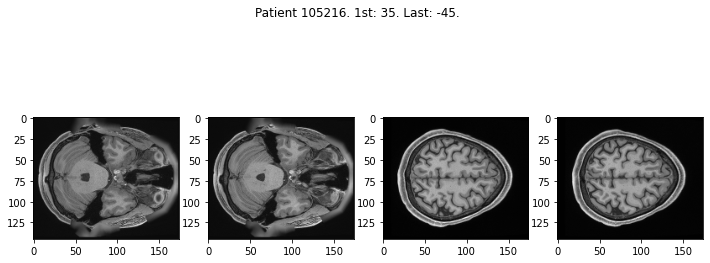

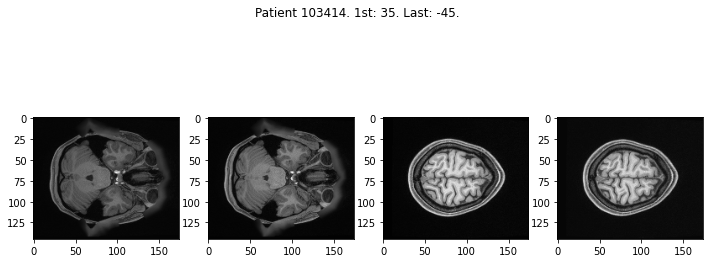

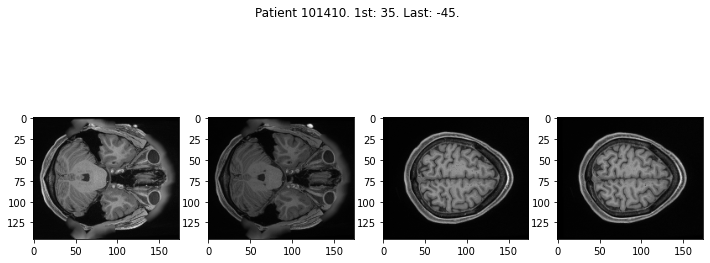

In [83]:
FIRST_IDX = 35
LAST_IDX = -45
slice_idx = [FIRST_IDX,FIRST_IDX+1,LAST_IDX-1, LAST_IDX]

random_scans = random.sample(remain_pids, 5)

for pat in random_scans:

    scan_path = os.path.join(main_folder, pat, 'T1w', nifti_filename)
    f = nib.load(scan_path)
    scan_array = f.get_fdata()

    fig = plt.figure(figsize=(12,5))
    fig.suptitle(f"Patient {pat.split('-')[0]}. 1st: {FIRST_IDX}. Last: {LAST_IDX}.")

    sub_figs = list(map(lambda i: fig.add_subplot(1,4,i), range(1, 5)))
    plots = list(map(lambda idx, sf: sf.imshow(scan_array[:,:,idx], cmap='gray'), slice_idx, sub_figs))

    plt.show()

### Keeping the strategy to choose one slice at every 5, the slice quantity and the number of slices with each scan given by the used sample is shown below.

In [84]:
img_from_sample = len(remain_pids) * (scan_array.shape[2] - FIRST_IDX + LAST_IDX) // 5
img_p_scan = img_from_sample/len(remain_pids)

img_from_sample, img_p_scan

(546, 13.0)

## TCGA Dataset.

### As we do not have segmented cancer or labeled slices, this separation will be done manually.

### It is a fact that images with positive or negative labels of the same patient should not be in the training and validation dataset.

### However, there is a hypothesis that the same patient contributing positive and negative images will bring robustness to the model.

### In order to avoid this excessive care, each patient will contribute a maximum of 3 slices per label.

In [18]:
tcga_folder = Path('../Datasets/Sample_TCGA-GBM/TCGA-GBM')

len(os.listdir())

19